In [225]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

KPI

- Cosine wave seasonality (cosine is 1 at angle =0, therefore makes it easier to adjust the peak by a number of weeks)
- Noise random sample norm distrib * amplitude multiplier - > then shifted up in yaxis to be >0 always
- Trend component:
    - (range /linspace with mean of zero)
    - then apply random stepping to trend to account for variation in trend effect by month
    - then multiply by noisy sine wave to add the trend component


In [71]:
(32.3+4.3+56+13.5+6.9)/5

22.6

In [73]:
#define all values up here so you can make all adjustments from one place
class Hardcoded:
    
    def __init__(self):
        self.years_of_data = 3
        self.annual_datapoints = 52
        self.peak_period_datapoint = 52-4 #(december) for cosine wave horizontal shifting
        self.mean_annual_turnover = 22_600_000_000 #get from sector reports 
        self.noise_scaling = 0.66
        self.trend_scaling = 0.4

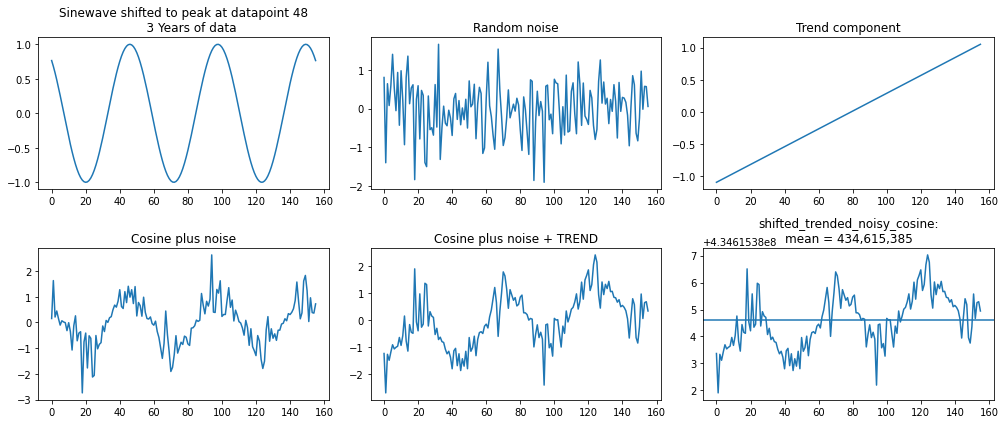

In [216]:
#create cosine wave
start_position = (Hardcoded().peak_period_datapoint/Hardcoded().annual_datapoints * 2*np.pi) * ((2*np.pi) / Hardcoded().annual_datapoints)
stop_position = start_position + (2*np.pi) * Hardcoded().years_of_data
array_len = Hardcoded().annual_datapoints * Hardcoded().years_of_data

cosine_angles_radians = np.linspace(
    start = start_position,
    stop = stop_position,
    num = array_len
)
cosine_wave = np.cos(cosine_angles_radians)

#introduce noise
noise = np.random.randn(array_len) * Hardcoded().noise_scaling
noisy_cosine = cosine_wave - (noise * cosine_wave)

#add trend 
t_minmax = np.linspace(noisy_cosine.min(),noisy_cosine.max(),array_len)
trend_gradient = Hardcoded().trend_scaling
trend_component = t_minmax * trend_gradient
trended_noisy_cosine = trend_component - noisy_cosine

#shift data on y axis
mean_val = Hardcoded().mean_annual_turnover / Hardcoded().annual_datapoints
final_kpi = trended_noisy_cosine + mean_val

###############
#plot evolution of data
fig,axes = plt.subplots(
    ncols=3, nrows=2, figsize=(14,6))

ax=axes[0][0]
ax.plot(cosine_wave)
ax.set_title(
    f"""Sinewave shifted to peak at datapoint {Hardcoded().peak_period_datapoint}
    {Hardcoded().years_of_data} Years of data""")

ax=axes[0][1]
ax.plot(noise)
ax.set_title(f'Random noise')

ax=axes[0][2]
ax.plot(trend_component)
ax.set_title(f'Trend component')

ax=axes[1][0]
ax.plot(noisy_cosine)
ax.set_title(f'Cosine plus noise')

ax=axes[1][1]
ax.plot(trended_noisy_cosine)
ax.set_title(f'Cosine plus noise + TREND')

ax=axes[1][2]
ax.plot(final_kpi)
ax.axhline(mean_val)
ax.set_title(f'shifted_trended_noisy_cosine:\nmean = {round(mean_val):,}')


fig.tight_layout()

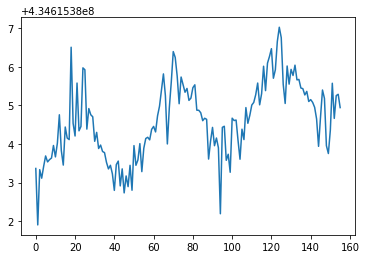

In [220]:
plt.plot(final_kpi)

In [226]:
np.savetxt('final_kpi.csv',final_kpi, delimiter=',')

# np.loadtxt('final_kpi.csv')

Channels data

In [364]:
def create_channel_data(name, chan_min, chan_max, use_pct=0.15, std_range_fraction=0.2):
    
    chan_range = chan_max - chan_min
    chan_std = chan_range * std_range_fraction
    chan_med = chan_max-(chan_range/2)
    use_num = int(array_len * use_pct)
    chan_zero = np.zeros(array_len - use_num)
    chan_use = np.random.normal(loc=chan_med, scale=chan_std, size=use_num) 
    chan = [np.random.choice(np.concatenate([chan_use,chan_zero])) for x in range(array_len)]
    
    todays_dt = datetime.today().date()
    dates = pd.date_range(end=todays_dt, periods=array_len, freq='1W-MON')
    weekly_chan = pd.DataFrame(chan, columns=[name], index=dates)
    return weekly_chan


def produce_spends():
    channels = []

    name = 'media_chan_1'
    use_pct = 0.15
    chan_min = 50_000
    chan_max = 125_000
    channels.append(create_channel_data(name, chan_min, chan_max, use_pct, std_range_fraction=0.8))

    name = 'media_chan_2'
    use_pct = 0.8
    chan_min = 8_000
    chan_max = 25_000
    channels.append(create_channel_data(name, chan_min, chan_max, use_pct, std_range_fraction=0.5))

    name = 'media_chan_3'
    use_pct = 0.05
    chan_min = 250_000
    chan_max = 800_000
    channels.append(create_channel_data(name, chan_min, chan_max, use_pct, std_range_fraction=0.4))

    channels_df = pd.concat(channels,axis=1)
    
    return channels_df

<AxesSubplot:>

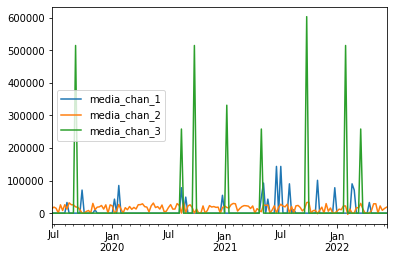

In [349]:
channels_df.plot()

In [370]:
tmp_df = produce_spends()
tmp_df = pd.concat([
    pd.Series(kpi, index=channels_df.index, name='kpi'),
    tmp_df
],axis=1)

counter = 0
while tmp_df.corr()['kpi'].iloc[1:].max() < 0.2:
    tmp_df = pd.concat([
        pd.Series(kpi, index=channels_df.index, name='kpi'),
        produce_spends()
    ],axis=1)
    
    if counter % 10 == 0:
        print(counter+1)
        
    counter += 1
    
print(f"success: max correlation was >20% at {tmp_df.corr()['kpi'].iloc[1:].max()}")

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
success: max correlation was >20% at 0.21120491875435554


In [372]:
tmp_df.corr()

,kpi,media_chan_1,media_chan_2,media_chan_3
kpi,1.000000,0.211205,-0.060993,-0.177599
media_chan_1,0.211205,1.000000,-0.166085,-0.080793
media_chan_2,-0.060993,-0.166085,1.000000,0.159125
media_chan_3,-0.177599,-0.080793,0.159125,1.000000


In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slig

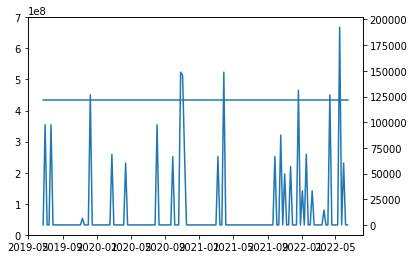

In [392]:
fig,ax = plt.subplots()

ax.plot(tmp_df['kpi'])
ax.set_ylim(0,7*10**8)

ax1 = ax.twinx()
ax1.plot(tmp_df['media_chan_1'])


<AxesSubplot:>

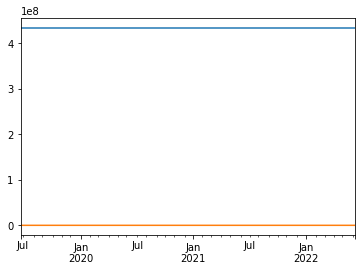

In [383]:
tmp_df['kpi'].plot() 
tmp_df['media_chan_1'].plot()

In [360]:
kpi = np.loadtxt('final_kpi.csv')

fake_data = pd.concat([
    pd.Series(kpi, index=channels_df.index, name='kpi'),
    channels_df
],axis=1)

In [363]:
fake_data.corr()

,kpi,media_chan_1,media_chan_2,media_chan_3
kpi,1.000000,0.000161,-0.187651,0.097113
media_chan_1,0.000161,1.000000,-0.223423,0.011150
media_chan_2,-0.187651,-0.223423,1.000000,0.050487
media_chan_3,0.097113,0.011150,0.050487,1.000000
